# Previously

We learned how to define neural networks plus the forward pass via using the MNIST dataset from using the weight matrices and matrix multiplications to using the `nn` PyTorch module. Do you remember that our results gave us a normal distribution? That's because we haven't trained yet our network. That's why we shall dive in now to training the neural network. 

# Objectives

In this notebook, we shall:
- change our perspective when we hear the word "training"
- learn the subprocesses of training
  - here we cover about losses, backpropagation, and optimizers 
- see how these subprocesses works as a whole

# Conceptual Overview of Training Neural Networks

## Neural networks with non-linear activations


<img src="https://github.com/lbleal1/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/function_approx.png?raw=true" width=500px>

- work like universal function approximators
  - there is some function that maps your input to the output. 
    For example, images of handwritten digits to class probabilities. The power of neural networks is that we can train them to approximate this function, and basically any function given enough data and compute time.




# Overview of Training Neural Networks

1. At first the network is naive, it doesn't know the function mapping the inputs to the outputs.

2. We train the network by showing it examples of real data, then adjusting the network parameters such that it approximates this function.

3. Find the Loss
To find these parameters stated in #2, we need to know how poorly the network is predicting the real outputs. For this we calculate a 
  
  **loss function** 
- also called the cost
- a measure of our prediction error
 For example, the mean squared loss is often used in regression and binary classification problems

4. Minimize Loss and Updating the weights
We then minimize this loss with respect to the network parameters, we can find configurations where the loss is at a minimum and the network is able to predict the correct labels with high accuracy.

**(2) Two Ways of Minimizing Loss**

  1. **Gradient Descent**
    - used for Single Layer Neural Networks
    - the process of finding this minimum
    :**gradient**
      - the slope of the loss function and points in the direction of 
      fastest change

    To get to the minimum in the least amount of time, we then want to 
    follow the gradient (downwards). You can think of this like 
    descending a mountain by following the steepest slope to the base.

<img src='https://github.com/lbleal1/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/gradient_descent.png?raw=true' width=350px>

  ***Remark:***
  However, it's more complicated for deeper, multilayer neural networks 
  like the one we've built. Complicated enough that it took about 30 
  years before researchers figured out how to train multilayer networks.

  2. **Backpropagation**
    - used in training multilayer networks
    - actually really just an application of the chain rule from calculus
    
    :**let's understand it using a two layer network converted into a graph representation**

    <img src='https://github.com/lbleal1/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/assets/backprop_diagram.png?raw=true' width=550px>

    **Forward Pass**
    -  our data and operations go from bottom to top here.
    1. We pass the input $x$ through a linear transformation $L_1$ with weights $W_1$ and biases $b_1$.
    2. The output then goes through the sigmoid operation $S$ and another linear transformation $L_2$.
    3.  Finally we calculate the loss $\ell$
    4. We use the loss as a measure of how bad the network's predictions are. The goal then is to adjust the weights and biases to minimize the loss.

    **Backpropagation**
    1.  We propagate the gradient of the loss backwards through the network
    *Each operation has some gradient between the inputs and outputs.
    2.  As we send the gradients backwards, we multiply the incoming gradient with the gradient for the operation.

    ***Remark:***
    - Mathematically, this is really just calculating the gradient of the loss with respect to the weights using the chain rule.
$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$
    3. We update our weights using this gradient with some learning rate $\alpha$. 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

The learning rate $\alpha$ is set such that the weight update steps are small enough that the iterative method settles in a minimum.


# Coding in PyTorch

## Losses

***Remark:***
- **convention:** we usually see the loss assigned to `criterion`
- To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels




### (2) Two Losses

#### 1. `nn.CrossEntropyLoss` 
  -  used together with softmax function (*recall:* softmax is used to predict class probabilities)
  - **important to note**
      - Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

        > This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
        >
        > The input is expected to contain scores for each class.
      - thus the **requirement for logits**, that is, we need to pass in the raw output of our network into the loss, not the output of the softmax function.

          **logits** 
          - also called *scores*
          - raw output of the network
      *We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one. 

    

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [2]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3367, grad_fn=<NllLossBackward>)


***Remark:***

It's usually best to avoid doing calculations with probabilities, that's why we typically use log-probabilities in the next loss

2. `nn.NLLLoss`
- used with a log-softmax output
- in PyTorch that's the output using `nn.LogSoftmax` or `F.log_softmax`
  
  *If you want to get the actual probabilities, 
      just take the exponential via `torch.exp(output)`

      

In [0]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# Define the loss
criterion = nn.NLLLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our log-probabilities
logps = model(images)
# Calculate the loss with the logps and the labels
loss = criterion(logps, labels)



***Remark:***
- Now that we know how to calculate a loss, how do we use it to perform backpropagation? we use PyTorch's autograd for that.

## Autograd for Backpropagation

`autograd`
- used for automatically calculating the gradients of tensors
- We can use it to calculate the gradients of all our parameters with respect to the loss. 

-works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. 

**(2) Two Ways to turn on and off gradients**

**1. via `requires_grad()` and `torch.no_grad()`**

*a. Turning On Gradients - `requires_grad()`*
 - to make sure PyTorch keeps track of operations on a tensor and 
   calculates the gradients, you need to set `requires_grad = True` on 
  a tensor. 
 - You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

*b. turning off gradients*
  - You can turn off gradients for a block of code with the `torch.no_grad()` content:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False
```

**2. via `torch.set_grad_enabled(True|False)`**



`z.backward()`
- The gradients are computed with respect to some variable `z` with `z.backward()`
- This does a backward pass through the operations that created `z`.

In [4]:
# Make data

x = torch.randn(2,2, requires_grad=True)
print(x)

y = x**2
print(y)

## grad_fn shows the function that generated this variable
print(y.grad_fn)

tensor([[ 0.9717,  1.3561],
        [-0.1351,  0.2677]], requires_grad=True)
tensor([[0.9442, 1.8391],
        [0.0183, 0.0717]], grad_fn=<PowBackward0>)


***Remark:**
- The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. 

Let's see this idea by reducing the tensor `y` to a scalar value, the mean.



In [5]:
z = y.mean()
print(z)

tensor(0.7183, grad_fn=<MeanBackward0>)


In [6]:
# You can check the gradients for `x` and `y` but they are empty currently.
print(x.grad)

None


To calculate the gradients, you need to run the `.backward` method on a Variable, `z` for example. This will calculate the gradient for `z` with respect to `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [7]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.4859,  0.6781],
        [-0.0676,  0.1339]])
tensor([[ 0.4859,  0.6781],
        [-0.0676,  0.1339]], grad_fn=<DivBackward0>)


***Remark:***
- These gradients calculations are particularly useful for neural networks.
  - For training we need the gradients of the weights with respect to the cost. 

***Overall***
- With PyTorch, we run data forward through the network to calculate the loss, then, go backwards to calculate the gradients with respect to the loss. Once we have the gradients we can make a gradient descent step. 

## Loss and Autograd together

- When we create a network with PyTorch, all of the parameters are initialized with `requires_grad = True`. 
  - This means that when we calculate the loss and call `loss.backward()`, the gradients for the parameters are calculated. 
  *These gradients are used to update the weights with gradient descent. 
  
Below you can see an example of calculating the gradients using a backwards pass.

In [0]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [9]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-9.2021e-05, -9.2021e-05, -9.2021e-05,  ..., -9.2021e-05,
         -9.2021e-05, -9.2021e-05],
        [-1.2114e-03, -1.2114e-03, -1.2114e-03,  ..., -1.2114e-03,
         -1.2114e-03, -1.2114e-03],
        [ 1.2627e-03,  1.2627e-03,  1.2627e-03,  ...,  1.2627e-03,
          1.2627e-03,  1.2627e-03],
        ...,
        [ 3.1334e-03,  3.1334e-03,  3.1334e-03,  ...,  3.1334e-03,
          3.1334e-03,  3.1334e-03],
        [ 4.5289e-04,  4.5289e-04,  4.5289e-04,  ...,  4.5289e-04,
          4.5289e-04,  4.5289e-04],
        [-2.0435e-03, -2.0435e-03, -2.0435e-03,  ..., -2.0435e-03,
         -2.0435e-03, -2.0435e-03]])


## Optimizer

**optimizer**
- used to update the weights with the gradients

  :**In PyTorch**
  -  We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html).
  
   For example we can use stochastic gradient descent with `optim.SGD`. 

### Defining an Optimizer

In [0]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Quick Sum Up

Now we know how to use all the individual parts so it's time to see how they work together. Let's consider just one learning step before looping through all the data. The general process with PyTorch:

* Make a forward pass through the network 
* Use the network output to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

# Going through all steps

## One Learning Step

Below I'll go through one training step and print out the weights and gradients so you can see how it changes.

In [11]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Clear the gradients, do this because gradients are accumulated
# When you do multiple backwards passes with the same parameters,
# the gradients are accumulated. 
#   This means that you need to zero the gradients 
#   on each training pass or you'll retain gradients 
#   from previous training batches.
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[-0.0291,  0.0109, -0.0265,  ..., -0.0184,  0.0193, -0.0245],
        [ 0.0114, -0.0024,  0.0065,  ...,  0.0165,  0.0199, -0.0042],
        [ 0.0166, -0.0240,  0.0055,  ...,  0.0243, -0.0064, -0.0009],
        ...,
        [-0.0191,  0.0280,  0.0040,  ...,  0.0184, -0.0340, -0.0246],
        [-0.0074,  0.0074, -0.0145,  ..., -0.0289,  0.0290, -0.0225],
        [-0.0352, -0.0027,  0.0258,  ...,  0.0221,  0.0111,  0.0179]],
       requires_grad=True)
Gradient - tensor([[-0.0028, -0.0028, -0.0028,  ..., -0.0028, -0.0028, -0.0028],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003],
        ...,
        [-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011],
        [ 0.0003,  0.0003,  0.0003,  ...,  0.0003,  0.0003,  0.0003],
        [ 0.0024,  0.0024,  0.0024,  ...,  0.0024,  0.0024,  0.0024]])


In [12]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[-0.0290,  0.0109, -0.0265,  ..., -0.0183,  0.0193, -0.0245],
        [ 0.0114, -0.0024,  0.0065,  ...,  0.0165,  0.0199, -0.0042],
        [ 0.0166, -0.0240,  0.0055,  ...,  0.0243, -0.0064, -0.0009],
        ...,
        [-0.0191,  0.0280,  0.0040,  ...,  0.0184, -0.0340, -0.0246],
        [-0.0074,  0.0074, -0.0145,  ..., -0.0289,  0.0290, -0.0225],
        [-0.0353, -0.0027,  0.0258,  ...,  0.0221,  0.0111,  0.0179]],
       requires_grad=True)


## 2. Looping through all images

**epoch**
- passing once through the entire dataset (in some nomenclature)

What we'll do below is:
- we're going to loop through `trainloader` to get our training batches.
-  For each batch, we'll doing a training pass where we calculate the loss, do a backwards pass, and update the weights.
**you should see the training loss drop with each epoch.

In [13]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # TODO: Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9591340685704115
Training loss: 0.8951495246910083
Training loss: 0.5321367342970265
Training loss: 0.4342518760832642
Training loss: 0.3901739557986575


With the network trained, we can check out it's predictions.

In [14]:
!wget https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py

--2020-01-09 15:28:16--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/3bd7dea850e936d8cb44adda8200e4e2b5d627e3/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py.2’

helper.py.2         100%[===================>]   2.75K  --.-KB/s    in 0s      

2020-01-09 15:28:16 (70.2 MB/s) - ‘helper.py.2’ saved [2813/2813]



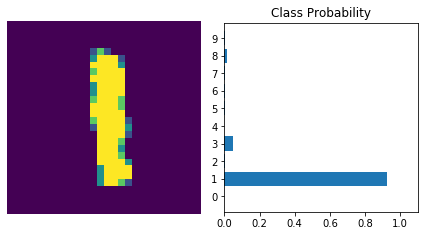

In [15]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

# Next up
ow our network is brilliant. It can accurately predict the digits in our images. Next up you'll write the code for training a neural network on a more complex dataset which is the Fashion-MNIST.